In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter
import lightgbm as lgb 
import pickle

In [293]:
raw_data = pd.read_pickle(r'C:\Users\niels\data\dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data.fillna(0.0,inplace=True)

C:\Users\niels\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [294]:
def f(x):

    if x > 0.01:
        return 1
    elif x < -0.01:

        return -1
    

    else:
    
        return 0

In [295]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True,)
data.set_index('date',inplace=True)

C:\Users\niels\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [296]:
df_1 = data.loc['2008-01-01':'2011-01-01']
df_2 = data.loc['2008-04-01':'2011-04-01']
df_valid = data.loc['2011-04-01':'2011-07-01']
df_test = data.loc['2011-07-01':'2011-10-01']

In [297]:
train_1 = df_1.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
train_2 = df_2.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

valid = df_valid.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)
test = df_test.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1)

In [298]:
train_1_stock_returns = df_1['next_period_return']
valid_stock_returns = df_valid['next_period_return']
train_2_stock_returns = df_2['next_period_return']
test_stock_returns = df_test['next_period_return']

y_1 = df_1['rel_performance']
y_2 = df_2['rel_performance']
y_valid = df_valid['rel_performance']
y_test = df_test['rel_performance']

y_1 = y_1.values
y_2 = y_2.values
y_valid = y_valid.values
y_test = y_test.values

In [299]:
gb_clf = lgb.LGBMClassifier(max_depth=4,n_estimators=400,objective='multi_class',min_child_samples=2000,
                            reg_lambda = 0.5,learning_rate=0.3,cegb_penalty_split=0.5,eval_set=(valid,y_valid))

In [300]:
gb_clf.fit(train_1,y_1)

LGBMClassifier(boosting_type='gbdt', cegb_penalty_split=0.5,
        class_weight=None, colsample_bytree=1.0,
        eval_set=(           actq        apq        atq       ceqq       cheq      cogsq  \
0      4145.196    401.338  15590.631  12511.290   3261.153    938.446
1      1569.712    200.179   3052.418   1096.242   1329.065    146.131
2      1410.098    269.763   6839.909   2291.630    202.173   1967.7...0
1545                  0

[1546 rows x 725 columns], array([-1, -1, ...,  1, -1], dtype=int64)),
        importance_type='split', learning_rate=0.3, max_depth=4,
        min_child_samples=2000, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=400, n_jobs=-1, num_leaves=31,
        objective='multi_class', random_state=None, reg_alpha=0.0,
        reg_lambda=0.5, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [301]:
gb_clf.score(train_1,y_1)

0.6999299050532084

In [302]:
preds = gb_clf.predict(valid)

In [303]:
gb_clf.score(valid,y_valid)

0.48641655886157825

In [304]:
confusion_matrix(y_valid,preds)

array([[269,   1, 528],
       [ 50,   1,  71],
       [144,   0, 482]], dtype=int64)

In [305]:
def gboost_feat_importances(m, df):
        
    return pd.DataFrame({'cols':df.columns, 'feat_imp': m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)

def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)

In [306]:
fi = gboost_feat_importances(gb_clf,train_1)

In [321]:
features = fi[(fi['feat_imp'] > 40)]

In [322]:
features.shape

(43, 2)

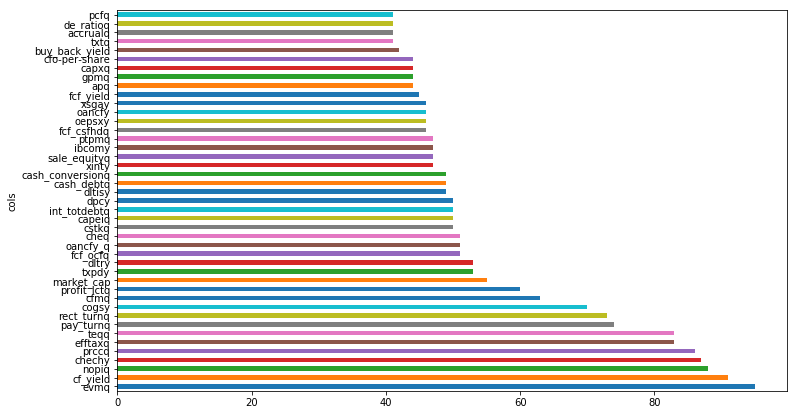

In [323]:
plot_fi(features);

In [324]:
features

,cols,feat_imp
95,evmq,95
105,cf_yield,91
36,nopiq,88
66,chechy,87
87,prccq,86
120,efftaxq,83
55,teqq,83
172,pay_turnq,74
171,rect_turnq,73
67,cogsy,70


In [325]:
train_1 = train_1[features['cols'].values]
valid = valid[features['cols'].values]

In [326]:
gb_clf.fit(train_1,y_1)
gb_clf.score(train_1,y_1)

0.6690881284649207

In [327]:
training = lgb.Dataset(train_1,y_1)
validation = lgb.Dataset(valid,y_valid)

In [328]:
pred_valid = gb_clf.predict(valid)
gb_clf.score(valid,y_valid)

0.4741267787839586

In [329]:
(pred_valid * valid_stock_returns).sum()

-26.460789

In [330]:
def profit_importance(m,df,rets):
#     np.random.seed(123)
    profit = []
    for col in df.columns:
        prof = []
        for _ in range(10):
            X = df.copy()
            X[col] = np.random.permutation(X[col].values)
            prediction = m.predict(X)
            prof.append((prediction * rets).sum())
        profit.append(np.mean(prof))
    return profit

In [331]:
def gbboost_profit_importance(m, df,rets):
    return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                       ).sort_values('pi_imp', ascending=True)

In [332]:
pi = gbboost_profit_importance(gb_clf,valid,valid_stock_returns)
pi

,cols,pi_imp
23,cash_debtq,-34.866079
28,ptpmq,-34.012273
39,txtq,-33.008892
42,pcfq,-31.599028
16,oancfy_q,-31.349607
30,oepsxy,-31.323785
24,cash_conversionq,-31.177966
7,pay_turnq,-30.917875
1,cf_yield,-30.911214
21,dpcy,-30.364190


In [333]:
profits = []
feat=[]

train = train_1.copy()
validation = valid.copy()

while len(train.columns)>1:

    pred_valid = gb_clf.predict(validation)
       
    print((pred_valid * df_valid['next_period_return']).sum())
    profits.append((pred_valid * df_valid['next_period_return']).sum())
    feat.append(train.columns)
    
    col_to_drop = pi.iloc[-1]['cols']
    train.drop(col_to_drop,axis=1,inplace=True)
    validation.drop(col_to_drop,axis=1,inplace=True)

    gb_clf.fit(train,y_1)
    pi = gbboost_profit_importance(gb_clf,validation,df_valid['next_period_return'])

-26.460789
-33.04586600000002
-24.043749999999996
-31.09483999999998
-23.698451999999968
-21.458838000000032
-24.134583999999982
-19.593375000000016
-30.939516000000012
-25.839162000000012
-34.39669400000001
-48.178157999999996
-51.80141199999997
-58.39125600000001
-53.551412
-63.10819000000002
-53.01832399999998
-55.563606
-47.92250199999999
-49.61950599999999
-44.02556800000002
-42.13476800000001
-36.37811600000003
-34.406244000000015
-38.889746
-35.057734
-36.952337999999976
-43.997949999999975
-43.058554
-35.35328799999999
-45.47336000000001
-50.997333999999995
-63.44145399999999
-61.453964000000035
-62.17614799999997
-59.96831999999999
-65.18777199999997
-67.12211399999997
-72.45844799999996
-69.41392399999995
-117.15319399999996
-124.99862799999995


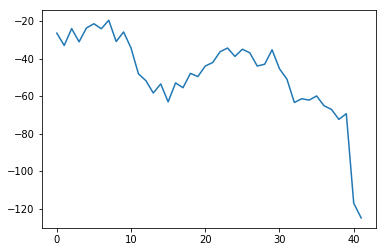

In [334]:
plt.plot(profits);

In [336]:
n = np.argmax(profits)
profits[n]

-19.593375000000016

In [337]:
optim_feats = feat[n]
optim_feats

Index(['evmq', 'cf_yield', 'nopiq', 'chechy', 'efftaxq', 'teqq', 'pay_turnq',
       'rect_turnq', 'cogsy', 'profit_lctq', 'market_cap', 'txpdy', 'dltry',
       'fcf_ocfq', 'oancfy_q', 'cheq', 'capeiq', 'int_totdebtq', 'dpcy',
       'cash_debtq', 'cash_conversionq', 'xinty', 'ibcomy', 'ptpmq',
       'fcf_csfhdq', 'oepsxy', 'oancfy', 'xsgay', 'fcf_yield', 'gpmq',
       'cfo-per-share', 'buy_back_yield', 'txtq', 'accrualq', 'de_ratioq',
       'pcfq'],
      dtype='object')

In [338]:
train_1_optim = train_1[optim_feats]
valid_optim = valid[optim_feats]


gb_clf.fit(train_1_optim,y_1)
print(gb_clf.score(train_1_optim,y_1))
pred_valid_tree = gb_clf.predict(valid_optim)
print(gb_clf.score(valid_optim,y_valid))
(pred_valid_tree * valid_stock_returns).sum()

0.6660931625565539
0.4883570504527814


-19.593375000000016

In [339]:
train_2_tree = train_2[optim_feats]
test_tree = test[optim_feats]
gb_clf.fit(train_2_tree,y_2)
pred_test_tree = gb_clf.predict(test_tree)
(pred_test_tree * test_stock_returns).sum()

10.240057999999973

In [340]:
from scipy.cluster import hierarchy as hc
import scipy.stats

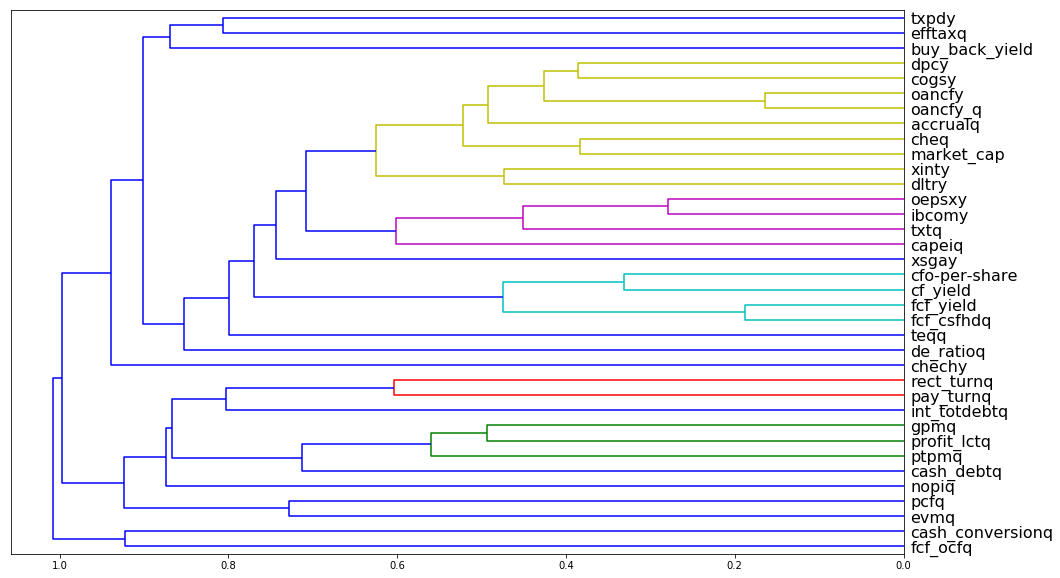

In [341]:
corr = np.round(scipy.stats.spearmanr(train_1_optim).correlation,4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=train_1_optim.columns, orientation='left', leaf_font_size=16)
plt.show()

In [65]:
start_dates = [pd.to_datetime('2000-01-01') + pd.DateOffset(months = 3 * i) for i in range(62)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [66]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

In [67]:
training_data = [d.reset_index().drop
                                 (['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

In [68]:
test_data = [d.reset_index().drop(['ticker','date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance','pred_rel_return',
                                  'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

In [69]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [342]:
opt_training_data = [t[optim_feats] for t in training_data]
opt_test_data = [v[optim_feats] for v in test_data]

In [343]:
P_L = []
x = [1]
ret = []

for i in range(len(training_labels)-1):
        gb_clf.fit(opt_training_data[i],training_labels[i])
        pred_i = gb_clf.predict(opt_test_data[i])
        profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
        P_L.append(profit_i)
        num_positions = len(pred_i)
        ret.append((1.0/num_positions) * profit_i)
        x.append(x[i] + (x[i]/num_positions) * profit_i)

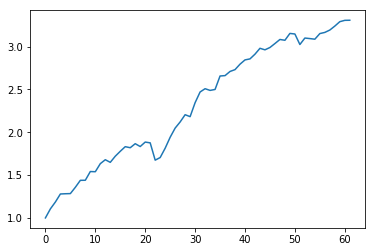

In [268]:
plt.plot(x);

In [269]:
SPY = pd.read_pickle(r'C:\Users\niels\data\SPY_cum_ret.pkl')
SPY = SPY.loc['2003-04-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x

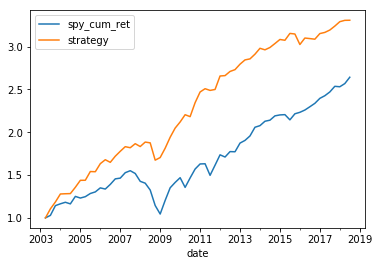

In [270]:
SPY.plot();

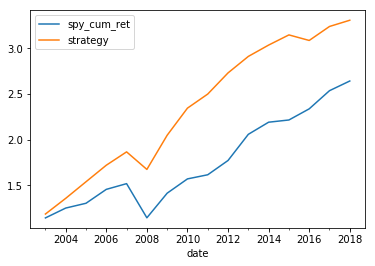

In [271]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [272]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret/strategy_std
print('Strategy Sharpe Ratio: ',strategy_sr)

Strategy Sharpe Ratio:  1.0561989649152683


In [198]:
x[-1]

3.7815840000832424

In [199]:
strategy_ret = (SPY['strategy'] - 1).diff().values[1:]
spy_ret = (SPY['spy_cum_ret'] - 1).diff().values[1:]

In [200]:
beta = (np.cov(spy_ret,strategy_ret)/np.var(spy_ret))[1,0]
beta

0.7410540621849192

In [201]:
residual_ret = strategy_ret - beta * spy_ret

In [202]:
IR = np.mean(residual_ret)/np.std(residual_ret)
IR

1.2145742112232227

In [203]:
alpha = np.mean(residual_ret)
alpha

0.09834384213391555